In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import MapType, StringType, IntegerType, ArrayType, StructType, \
                              StructField, LongType, DoubleType, BooleanType, FloatType, BinaryType, TimestampType
import pyspark.sql.functions as F
import pyspark

from IPython.display import display, clear_output
import time
from wordcloud import WordCloud, STOPWORDS

from time import sleep
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Creating Spark Session

In [63]:
# Initialise Spark session
spark = SparkSession.builder \
        .appName('kafka') \
        .config("spark.sql.streaming.schemaInference", True) \
        .getOrCreate()

sc = spark.sparkContext

In [64]:
## To always show the results of DataFrames and improve the formatting of the output
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To allow future conversion of Spark DataFrame into Pandas DataFrame
spark.conf.set("spark.sql.execution.arrow.enabled", True)

# Step 2: Building Spark Streaming DF from `EngTweets` topic

In [65]:
# Read data from the topic 
raw_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("subscribe", "engtweets") \
  .option("startingOffsets","earliest") \
  .option("includeHeaders", "true") \
  .load()

In [66]:
raw_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)
 |-- headers: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: binary (nullable = true)



In [67]:
# Schema of the EngTweets data
hashtag_schema = StructType([
    StructField("TEXT", StringType(),  True),
    StructField("START", IntegerType(),  True),
    StructField("END", IntegerType(),  True),
    ]
)

engtweets_schema = StructType([
    StructField("CREATEDAT", LongType(),  True),
    StructField("ID", LongType(),  True),
    StructField("USER_ID", LongType(),  True),
    StructField("USER_NAME", StringType(),  True),
    StructField("SCREENNAME", StringType(),  True),
    StructField("USER_LOCATION", StringType(), True),
    StructField("FOLLOW_COUNT", IntegerType(),  True),
    StructField("FRIEND_COUNT", IntegerType(),  True),
    StructField("USER_CREAT_AT", LongType(),  True),
    StructField("USER_FAV_COUNT", IntegerType(), True),
    StructField("USER_VERIFIED", BooleanType(), True),
    StructField("USER_LANG", StringType(),  True),
    StructField("TEXT", StringType(),  True),
    StructField("LANG", StringType(),  True),
    StructField("GAO_LAT", DoubleType(), True),
    StructField("GEO_LONG", DoubleType(),  True),
    StructField("PLACE_NAME", StringType(),  True),
    StructField("PLACE_COUNTRY", StringType(), True),
    StructField("HASHTAG", ArrayType(hashtag_schema), True),
    StructField("USER_MENTION_NAME", ArrayType( StringType()), True)
    ]
)

In [68]:
# Transform engtweets topic based on the schema and select required columns
transformed_df = raw_df.selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)", "timestamp")\
    .withColumn("value", F.from_json("value", engtweets_schema)) \
    .withColumn("timestamp", F.col("timestamp").cast(TimestampType())) \
    .select('timestamp', F.col('value.*'))

In [69]:
transformed_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- CREATEDAT: long (nullable = true)
 |-- ID: long (nullable = true)
 |-- USER_ID: long (nullable = true)
 |-- USER_NAME: string (nullable = true)
 |-- SCREENNAME: string (nullable = true)
 |-- USER_LOCATION: string (nullable = true)
 |-- FOLLOW_COUNT: integer (nullable = true)
 |-- FRIEND_COUNT: integer (nullable = true)
 |-- USER_CREAT_AT: long (nullable = true)
 |-- USER_FAV_COUNT: integer (nullable = true)
 |-- USER_VERIFIED: boolean (nullable = true)
 |-- USER_LANG: string (nullable = true)
 |-- TEXT: string (nullable = true)
 |-- LANG: string (nullable = true)
 |-- GAO_LAT: double (nullable = true)
 |-- GEO_LONG: double (nullable = true)
 |-- PLACE_NAME: string (nullable = true)
 |-- PLACE_COUNTRY: string (nullable = true)
 |-- HASHTAG: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- TEXT: string (nullable = true)
 |    |    |-- START: integer (nullable = true)
 |    |    |-- END: integer (n

# Step 3: Cleaning HashTags

## Cleaning text

In [76]:
# 1) Explode HASHTAG ARRAY
# 2) Select only the TEXT column from HASHTAG
# 3) Keep only TEXT (word) column that are not null
# 4) To lower letter

cleaned_df = transformed_df \
    .select('timestamp', F.explode(F.col('HASHTAG')).alias('HASHTAG')) \
    .select('timestamp', F.col('HASHTAG.TEXT').alias('word')) \
    .filter(F.col('word').isNotNull()) \
    .withColumn('word', F.lower(F.col('word')))

In [77]:
cleaned_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- word: string (nullable = true)



# Step 4: Creating window stream (60 minutes)

## Window Operations on Event Time
In a `grouped aggregation`, aggregate values (counts) are maintained for each unique value in the user-specified grouping column (word). In case of `window-based aggregations`, aggregate values are maintained for each window the event-time of a row falls into.

*Instead of running* word counts, we want to count words `within 60 minute` windows, `updating every 5 minutes`. That is, word counts in words received `between 60 minute` windows `12:00` - `13:00`, `12:05` - `13:05`, `12:10` - `13:10`, etc. Note that `12:00` - `13:00` means data that arrived after `12:00` but before `13:00`. Now, consider a word that was received at `12:07`. This word should increment the counts corresponding to two windows `12:00` - `13:00` and `12:05` - `13:05`. So the counts will be indexed by both, the grouping key (i.e. the `word`) and the window (can be calculated from the event-time).

## Handling Late Data and Watermarking 

Now consider what happens if one of the events arrives late to the application. For example, say, a word generated at `12:04` (i.e. event time) could be received by the application at `13:01`. The application should use the time `12:04` instead of `13:01` to update the older counts for the window `12:00` - `13:00`. This occurs naturally in our window-based grouping – Structured Streaming can maintain the intermediate state for partial aggregates for a long period of time such that late data can update aggregates of old windows correctly


In [151]:
# Group hashtags using window function
word_count = cleaned_df \
    .withWatermark("timestamp", "60 minutes") \
    .groupBy(
        F.window(F.col('timestamp'), "60 minutes", "5 minutes"),
        F.col('word')) \
    .count()

In [152]:
word_count.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- word: string (nullable = true)
 |-- count: long (nullable = false)



# Step 5: Creating Query

In [153]:
# Read the data stream into memory buffer. 
query_stream_memory = word_count \
    .writeStream \
    .format("memory") \
    .queryName("word_cloud") \
    .outputMode("complete") \
    .start()

# Step 6: Visualising WordCLoud

**********************
General Info
**********************
Run : 1
Stream timestamp : 2021-06-11T18:07:19.198Z
**********************
Window
**********************


,start,end
0,2021-06-11 17:05:00,2021-06-11 18:05:00


**********************
Rows in Dataframe
**********************


,Row_count
0,3305


-------------------------------------------------------------------
**********************
Visualise Trending HashTag using WordCloud
**********************


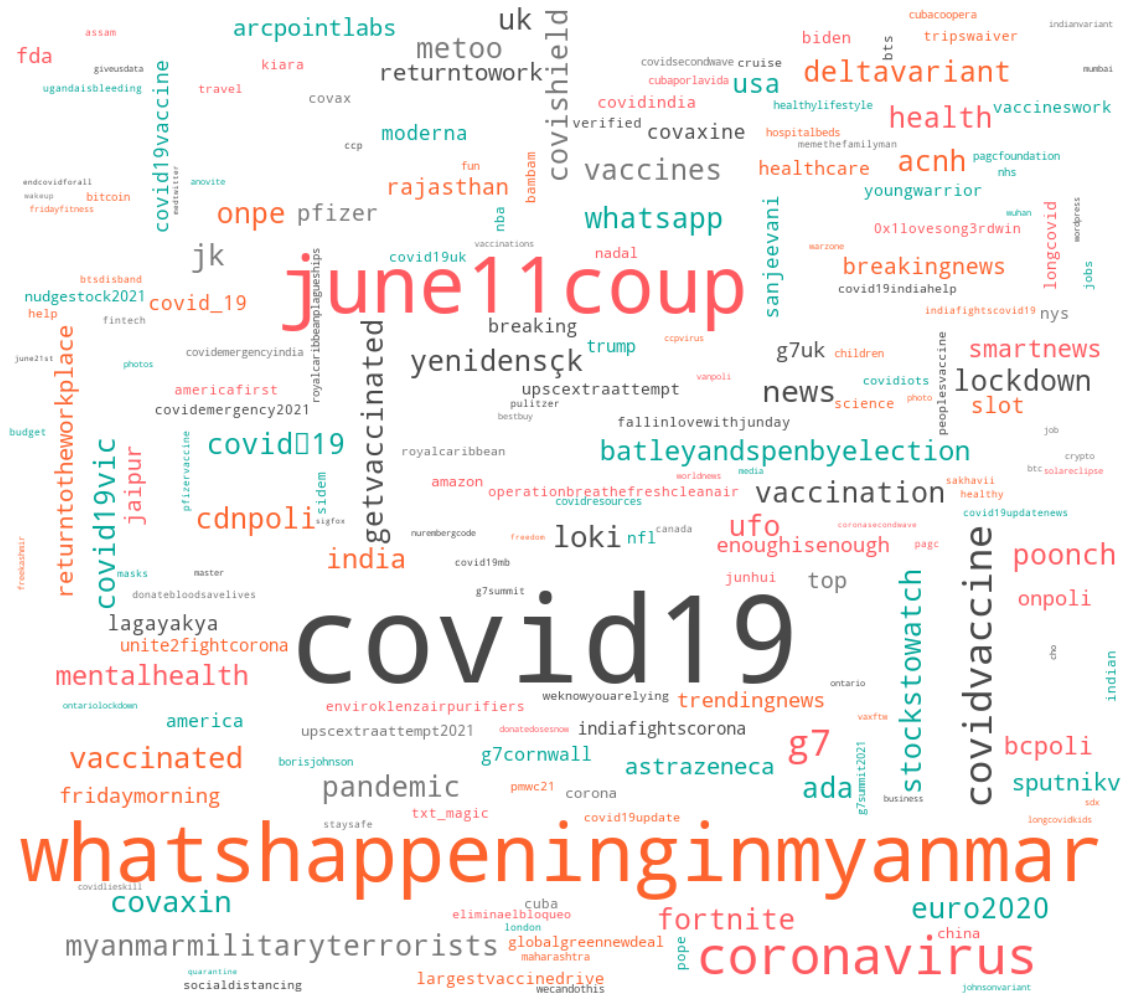

Halting the process for 5 Minutes...
Process interrupted.


In [156]:
matplotlib.rc('font', family='DejaVu Sans')

try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run : {}".format(i))
        if (len(query_stream_memory.recentProgress) > 0):
            print("Stream timestamp : {}".format(query_stream_memory.lastProgress["timestamp"]))
        print("**********************")
        print("Window")
        print("**********************")
        # It get the max window timestamp that has ended
        df_row = spark.sql("""
                            SELECT MAX(w.window.start) as start, MAX(w.window.end) as end
                            FROM word_cloud as w
                            WHERE w.word != 'covid' and w.word != 'covid-19' and w.word != 'vaccine' and w.window.start = (SELECT MAX(window.start) as max_start FROM word_cloud WHERE window.end < now())
                            """
                          ).toPandas()
        display(df_row)
        
        print("**********************")
        print("Rows in Dataframe")
        print("**********************")
        # Count the rows using the same filter
        df_row = spark.sql("""
                            SELECT count(*) as Row_count 
                            FROM word_cloud as w
                            WHERE w.word != 'covid' and w.word != 'covid-19' and w.word != 'vaccine' and w.window.start = (SELECT MAX(window.start) as max_start FROM word_cloud WHERE window.end < now())
                            """
                          ).toPandas()
        display(df_row)

        print("-------------------------------------------------------------------")
        # It gets the word count of the last window that has ended
        df = spark.sql(
                """
                    SELECT
                        w.word, w.count
                    FROM
                        word_cloud as w
                    WHERE
                        w.word != 'covid' and w.word != 'covid-19' and w.word != 'vaccine' and w.window.start = (SELECT MAX(window.start) as max_start FROM word_cloud WHERE window.end < now())
                """
        ).toPandas()

        ## Clean the dataframe using pandas
        #Groupby and sort the word based on count
        grouped = df.groupby(['word']).sum().sort_values(by=['count'], ascending=False)
        # Ungroup the dataframe 
        grouped.reset_index(drop=False, inplace=True)
        # Only select word with count more than or equal to five.
        grouped = grouped.loc[grouped['count'] >= 5]
        # Create a dictionary from the dataframe
        word_freq = grouped.set_index('word').to_dict()['count']

        ## Initialize the matplotlib figure and wordcloud default settings
        plt.figure(figsize=(20, 20))
        # Initialise StopWords
        stopwords = set(STOPWORDS)
        # Define fixed colour schema for wordcloud
        def setListOfcolor_func(word=None, font_size=None,  
                    position=None, orientation=None,  
                    font_path=None, random_state=None):  
            #define the list of set colors  
            color_list = ["#ff5a60", "#00a698", "#fd632d", "#484848", "#767676"]  
            #return a random color in the list  
            return np.random.choice(color_list)

        print("**********************")
        print("Visualise Trending HashTag using WordCloud")
        print("**********************")
        try:
            # Initialise WordCloud
            wc = WordCloud(stopwords=stopwords, background_color="white", width = 900, height = 800,
                      color_func=setListOfcolor_func) \
                .generate_from_frequencies(word_freq)

            # Plot wordcloud
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass

        print("Halting the process for 5 Minutes...")
        # Pause the execution for 5 minutes
        sleep(300)
        # Increase Run count
        i=i+1
except KeyboardInterrupt:
    print("Process interrupted.")

In [150]:
# Stop the write Streams
query_stream_memory.stop()

In [62]:
# Stop the spark session
spark.stop()